In [1]:
%load_ext autoreload
%autoreload 2

# Load libraries and sample data

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


ticker_list = [
    "SPY",
    "GLD", 
    "TLT",
    "DBA", 
    "DBB", 
    "USO",
    "UUP",
]
price_data = {}
for ticker in ticker_list:
    # Load sample data
    df = pd.read_pickle(f'data/raw/price/{ticker}_20250202.pkl')
    df.set_index('Date', inplace=True)
    # data.index = pd.to_datetime(data.index, format="mixed")
    price_data[ticker] = df

# Trend following strategy

In [3]:
from strategies.trend_following import AdvancedTrendFollowingStrategy
from utils.backtester import BackTester

# Initialize backtester
bt = BackTester(price_data)
bt.add_strategy(
    AdvancedTrendFollowingStrategy, 
    tickers=ticker_list, 
    price_data=price_data, 
    fast_lookback={ticker: 10 for ticker in ticker_list},
    slow_lookback={ticker: 400 for ticker in ticker_list},
    rebalance_period=5,
    atr_period=21,
    correction_fast_weight={ticker: 0.1 for ticker in ticker_list},
    rebound_fast_weight={ticker: 0.8 for ticker in ticker_list},
    sma_trend_periods=(21, 252),
)
results = bt.backtest()
print("Trend following Results:", {k: v for k, v in results.items() if k != 'returns'})
bt.plot_results()

Trend following Results: {'cagr': 0.03210933374164582, 'volatility': 0.07793141940615475, 'sharpe': 0.41202038903335997, 'max_drawdown': 0.16221298572987278, 'cumulative_returns': 0.6746119600049372}


# Optuna

In [4]:
import optuna

def optuna_study(ticker, df, num_trials=100):
    ticker_list = [ticker]
    price_data = {ticker: df}

    def objective(trial):
        
        # Define the ranges for the numerical parameters
        fast_lookback = {ticker: trial.suggest_int(f'fast_lookback_{ticker}', 10, 100) for ticker in ticker_list}
        slow_lookback = {ticker: trial.suggest_int(f'slow_lookback_{ticker}', 50, 252) for ticker in ticker_list}
        rebalance_period = 21
        atr_period = 21
        
        # Define the ranges for the weights
        correction_fast_weight = {ticker: trial.suggest_float(f'correction_fast_weight_{ticker}', 0.0, 1.0) for ticker in ticker_list}
        rebound_fast_weight = {ticker: trial.suggest_float(f'rebound_fast_weight_{ticker}', 0.0, 1.0) for ticker in ticker_list}

        sma_trend_periods = (21, 252)

        # Initialize the BackTester
        bt = BackTester(price_data)
        
        # Add the strategy with the suggested parameters
        bt.add_strategy(
            AdvancedTrendFollowingStrategy, 
            tickers=ticker_list, 
            price_data=price_data, 
            fast_lookback=fast_lookback,
            slow_lookback=slow_lookback,
            rebalance_period=rebalance_period,
            atr_period=atr_period,
            correction_fast_weight=correction_fast_weight,
            rebound_fast_weight=rebound_fast_weight,
            sma_trend_periods=sma_trend_periods,
        )
        
        # Run the backtest
        results = bt.backtest()

        return results['cagr']

    # Create a study object and optimize the objective function
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=num_trials)

    # Output the best parameters
    print(study.best_params)

    study.trials_dataframe().to_csv(f'./optuna_logs/trend_following_individual_asset/optuna_study_results_{ticker}_cagr.csv')

    return study.best_params

individual_asset_study_results = {}
for ticker in tqdm(ticker_list):
    best_params = optuna_study(ticker, price_data[ticker], num_trials=100)
    individual_asset_study_results[ticker] = best_params

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2025-02-03 09:30:28,117] A new study created in memory with name: no-name-1e9e4519-8deb-4a1f-8b61-0e294a33ece6
[I 2025-02-03 09:30:32,259] Trial 0 finished with value: 0.054684608874523866 and parameters: {'fast_lookback_SPY': 55, 'slow_lookback_SPY': 58, 'correction_fast_weight_SPY': 0.1544458409847672, 'rebound_fast_weight_SPY': 0.18519047236855457}. Best is trial 0 with value: 0.054684608874523866.
[I 2025-02-03 09:30:36,247] Trial 1 finished with value: 0.05782995704992078 and parameters: {'fast_lookback_SPY': 52, 'slow_lookback_SPY': 68, 'correction_fast_weight_SPY': 0.6307461501897363, 'rebound_fast_weight_SPY': 0.3945130795198185}. Best is trial 1 with value: 0.05782995704992078.
[I 2025-02-03 09:30:40,234] Trial 2 finished with value: 0.08093711047388741 and parameters: {'fast_lookback_SPY': 22, 'slow_lookback_SPY': 247, 'correction_fast_weight_SPY': 0.2579680920898978, 'rebound_fast_weight_SPY': 0.07649474392133937}. Best is trial 2 with value: 0.08093711047388741.
[I 2025-

{'fast_lookback_SPY': 14, 'slow_lookback_SPY': 206, 'correction_fast_weight_SPY': 0.001714428050531223, 'rebound_fast_weight_SPY': 0.9988903915128886}


[I 2025-02-03 09:37:17,969] Trial 0 finished with value: 0.06432080135394869 and parameters: {'fast_lookback_GLD': 37, 'slow_lookback_GLD': 162, 'correction_fast_weight_GLD': 0.26356460994489483, 'rebound_fast_weight_GLD': 0.8296975083342367}. Best is trial 0 with value: 0.06432080135394869.
[I 2025-02-03 09:37:20,495] Trial 1 finished with value: 0.026484345140114884 and parameters: {'fast_lookback_GLD': 45, 'slow_lookback_GLD': 184, 'correction_fast_weight_GLD': 0.2621185034296146, 'rebound_fast_weight_GLD': 0.11438685418331096}. Best is trial 0 with value: 0.06432080135394869.
[I 2025-02-03 09:37:23,004] Trial 2 finished with value: 0.014156703709380603 and parameters: {'fast_lookback_GLD': 31, 'slow_lookback_GLD': 70, 'correction_fast_weight_GLD': 0.7628671562694542, 'rebound_fast_weight_GLD': 0.2634629116576451}. Best is trial 0 with value: 0.06432080135394869.
[I 2025-02-03 09:37:25,547] Trial 3 finished with value: 0.033407140683506364 and parameters: {'fast_lookback_GLD': 10, '

{'fast_lookback_GLD': 38, 'slow_lookback_GLD': 156, 'correction_fast_weight_GLD': 0.025010046252790227, 'rebound_fast_weight_GLD': 0.9504830871144825}


[I 2025-02-03 09:41:35,757] Trial 0 finished with value: 0.0031211182197594667 and parameters: {'fast_lookback_TLT': 63, 'slow_lookback_TLT': 155, 'correction_fast_weight_TLT': 0.5926134943831093, 'rebound_fast_weight_TLT': 0.599384129975198}. Best is trial 0 with value: 0.0031211182197594667.
[I 2025-02-03 09:41:38,592] Trial 1 finished with value: -0.006516279799724578 and parameters: {'fast_lookback_TLT': 12, 'slow_lookback_TLT': 218, 'correction_fast_weight_TLT': 0.6442232914332974, 'rebound_fast_weight_TLT': 0.4666724130874931}. Best is trial 0 with value: 0.0031211182197594667.
[I 2025-02-03 09:41:41,394] Trial 2 finished with value: 0.0072882533710521 and parameters: {'fast_lookback_TLT': 94, 'slow_lookback_TLT': 71, 'correction_fast_weight_TLT': 0.6608509396040095, 'rebound_fast_weight_TLT': 0.6176434778643227}. Best is trial 2 with value: 0.0072882533710521.
[I 2025-02-03 09:41:44,197] Trial 3 finished with value: 0.0029607515146354846 and parameters: {'fast_lookback_TLT': 20,

{'fast_lookback_TLT': 40, 'slow_lookback_TLT': 50, 'correction_fast_weight_TLT': 0.7170153684268423, 'rebound_fast_weight_TLT': 0.8687380613392205}


[I 2025-02-03 09:46:15,990] Trial 0 finished with value: 0.03796140428745853 and parameters: {'fast_lookback_DBA': 93, 'slow_lookback_DBA': 169, 'correction_fast_weight_DBA': 0.9184714336248601, 'rebound_fast_weight_DBA': 0.2306364257029685}. Best is trial 0 with value: 0.03796140428745853.
[I 2025-02-03 09:46:18,176] Trial 1 finished with value: 0.025289753497747647 and parameters: {'fast_lookback_DBA': 56, 'slow_lookback_DBA': 74, 'correction_fast_weight_DBA': 0.09230718482931266, 'rebound_fast_weight_DBA': 0.6142662187543815}. Best is trial 0 with value: 0.03796140428745853.
[I 2025-02-03 09:46:20,362] Trial 2 finished with value: 0.01736772846500889 and parameters: {'fast_lookback_DBA': 76, 'slow_lookback_DBA': 213, 'correction_fast_weight_DBA': 0.041531935672125764, 'rebound_fast_weight_DBA': 0.6697017185842937}. Best is trial 0 with value: 0.03796140428745853.
[I 2025-02-03 09:46:22,549] Trial 3 finished with value: 0.02692049488295334 and parameters: {'fast_lookback_DBA': 86, 's

{'fast_lookback_DBA': 88, 'slow_lookback_DBA': 93, 'correction_fast_weight_DBA': 0.9197087906691678, 'rebound_fast_weight_DBA': 0.9091781753554702}


[I 2025-02-03 09:50:10,648] Trial 0 finished with value: -0.0255211392785496 and parameters: {'fast_lookback_DBB': 11, 'slow_lookback_DBB': 239, 'correction_fast_weight_DBB': 0.5341806426823066, 'rebound_fast_weight_DBB': 0.04604095964799948}. Best is trial 0 with value: -0.0255211392785496.
[I 2025-02-03 09:50:13,042] Trial 1 finished with value: -0.0671990996026266 and parameters: {'fast_lookback_DBB': 19, 'slow_lookback_DBB': 171, 'correction_fast_weight_DBB': 0.9918041722140436, 'rebound_fast_weight_DBB': 0.6115381433470357}. Best is trial 0 with value: -0.0255211392785496.
[I 2025-02-03 09:50:15,428] Trial 2 finished with value: 0.0016400213047664813 and parameters: {'fast_lookback_DBB': 46, 'slow_lookback_DBB': 243, 'correction_fast_weight_DBB': 0.474358449152956, 'rebound_fast_weight_DBB': 0.8080503848678996}. Best is trial 2 with value: 0.0016400213047664813.
[I 2025-02-03 09:50:17,817] Trial 3 finished with value: -0.0071127939206984125 and parameters: {'fast_lookback_DBB': 65

{'fast_lookback_DBB': 48, 'slow_lookback_DBB': 102, 'correction_fast_weight_DBB': 0.002159663897425834, 'rebound_fast_weight_DBB': 0.9455276130558529}


[I 2025-02-03 09:54:03,802] Trial 0 finished with value: 0.027003722606610214 and parameters: {'fast_lookback_USO': 50, 'slow_lookback_USO': 236, 'correction_fast_weight_USO': 0.9334472905462815, 'rebound_fast_weight_USO': 0.43272185931554297}. Best is trial 0 with value: 0.027003722606610214.
[I 2025-02-03 09:54:06,115] Trial 1 finished with value: 0.022112946054817728 and parameters: {'fast_lookback_USO': 63, 'slow_lookback_USO': 231, 'correction_fast_weight_USO': 0.3268575915522426, 'rebound_fast_weight_USO': 0.3524965427885304}. Best is trial 0 with value: 0.027003722606610214.
[I 2025-02-03 09:54:08,411] Trial 2 finished with value: 0.057615507741163086 and parameters: {'fast_lookback_USO': 75, 'slow_lookback_USO': 176, 'correction_fast_weight_USO': 0.9876626816179712, 'rebound_fast_weight_USO': 0.40026184070764526}. Best is trial 2 with value: 0.057615507741163086.
[I 2025-02-03 09:54:10,721] Trial 3 finished with value: 0.04567987129244622 and parameters: {'fast_lookback_USO': 5

{'fast_lookback_USO': 10, 'slow_lookback_USO': 68, 'correction_fast_weight_USO': 0.8320065026027207, 'rebound_fast_weight_USO': 0.8912096729144374}


[I 2025-02-03 09:57:58,207] Trial 0 finished with value: 0.005974967642133233 and parameters: {'fast_lookback_UUP': 59, 'slow_lookback_UUP': 136, 'correction_fast_weight_UUP': 0.3531482333890166, 'rebound_fast_weight_UUP': 0.7612136831759552}. Best is trial 0 with value: 0.005974967642133233.
[I 2025-02-03 09:58:00,373] Trial 1 finished with value: 0.019344596645229917 and parameters: {'fast_lookback_UUP': 71, 'slow_lookback_UUP': 205, 'correction_fast_weight_UUP': 0.542769241683267, 'rebound_fast_weight_UUP': 0.9694834927848531}. Best is trial 1 with value: 0.019344596645229917.
[I 2025-02-03 09:58:02,554] Trial 2 finished with value: 0.00336419966536905 and parameters: {'fast_lookback_UUP': 49, 'slow_lookback_UUP': 212, 'correction_fast_weight_UUP': 0.1966913723155056, 'rebound_fast_weight_UUP': 0.3257659013237467}. Best is trial 1 with value: 0.019344596645229917.
[I 2025-02-03 09:58:04,745] Trial 3 finished with value: 0.010578735420908592 and parameters: {'fast_lookback_UUP': 42, 

{'fast_lookback_UUP': 69, 'slow_lookback_UUP': 71, 'correction_fast_weight_UUP': 0.9085526758881113, 'rebound_fast_weight_UUP': 0.9682531156721502}


## Combine individual assets into single portfolio

In [5]:
individual_asset_study_results

{'SPY': {'fast_lookback_SPY': 14,
  'slow_lookback_SPY': 206,
  'correction_fast_weight_SPY': 0.001714428050531223,
  'rebound_fast_weight_SPY': 0.9988903915128886},
 'GLD': {'fast_lookback_GLD': 38,
  'slow_lookback_GLD': 156,
  'correction_fast_weight_GLD': 0.025010046252790227,
  'rebound_fast_weight_GLD': 0.9504830871144825},
 'TLT': {'fast_lookback_TLT': 40,
  'slow_lookback_TLT': 50,
  'correction_fast_weight_TLT': 0.7170153684268423,
  'rebound_fast_weight_TLT': 0.8687380613392205},
 'DBA': {'fast_lookback_DBA': 88,
  'slow_lookback_DBA': 93,
  'correction_fast_weight_DBA': 0.9197087906691678,
  'rebound_fast_weight_DBA': 0.9091781753554702},
 'DBB': {'fast_lookback_DBB': 48,
  'slow_lookback_DBB': 102,
  'correction_fast_weight_DBB': 0.002159663897425834,
  'rebound_fast_weight_DBB': 0.9455276130558529},
 'USO': {'fast_lookback_USO': 10,
  'slow_lookback_USO': 68,
  'correction_fast_weight_USO': 0.8320065026027207,
  'rebound_fast_weight_USO': 0.8912096729144374},
 'UUP': {'fas

Trend following Results: {'cagr': 0.03971611221899107, 'volatility': 0.10390202057481593, 'sharpe': 0.3822458119608271, 'max_drawdown': 0.2639058246650208, 'cumulative_returns': 0.9317024477514015}


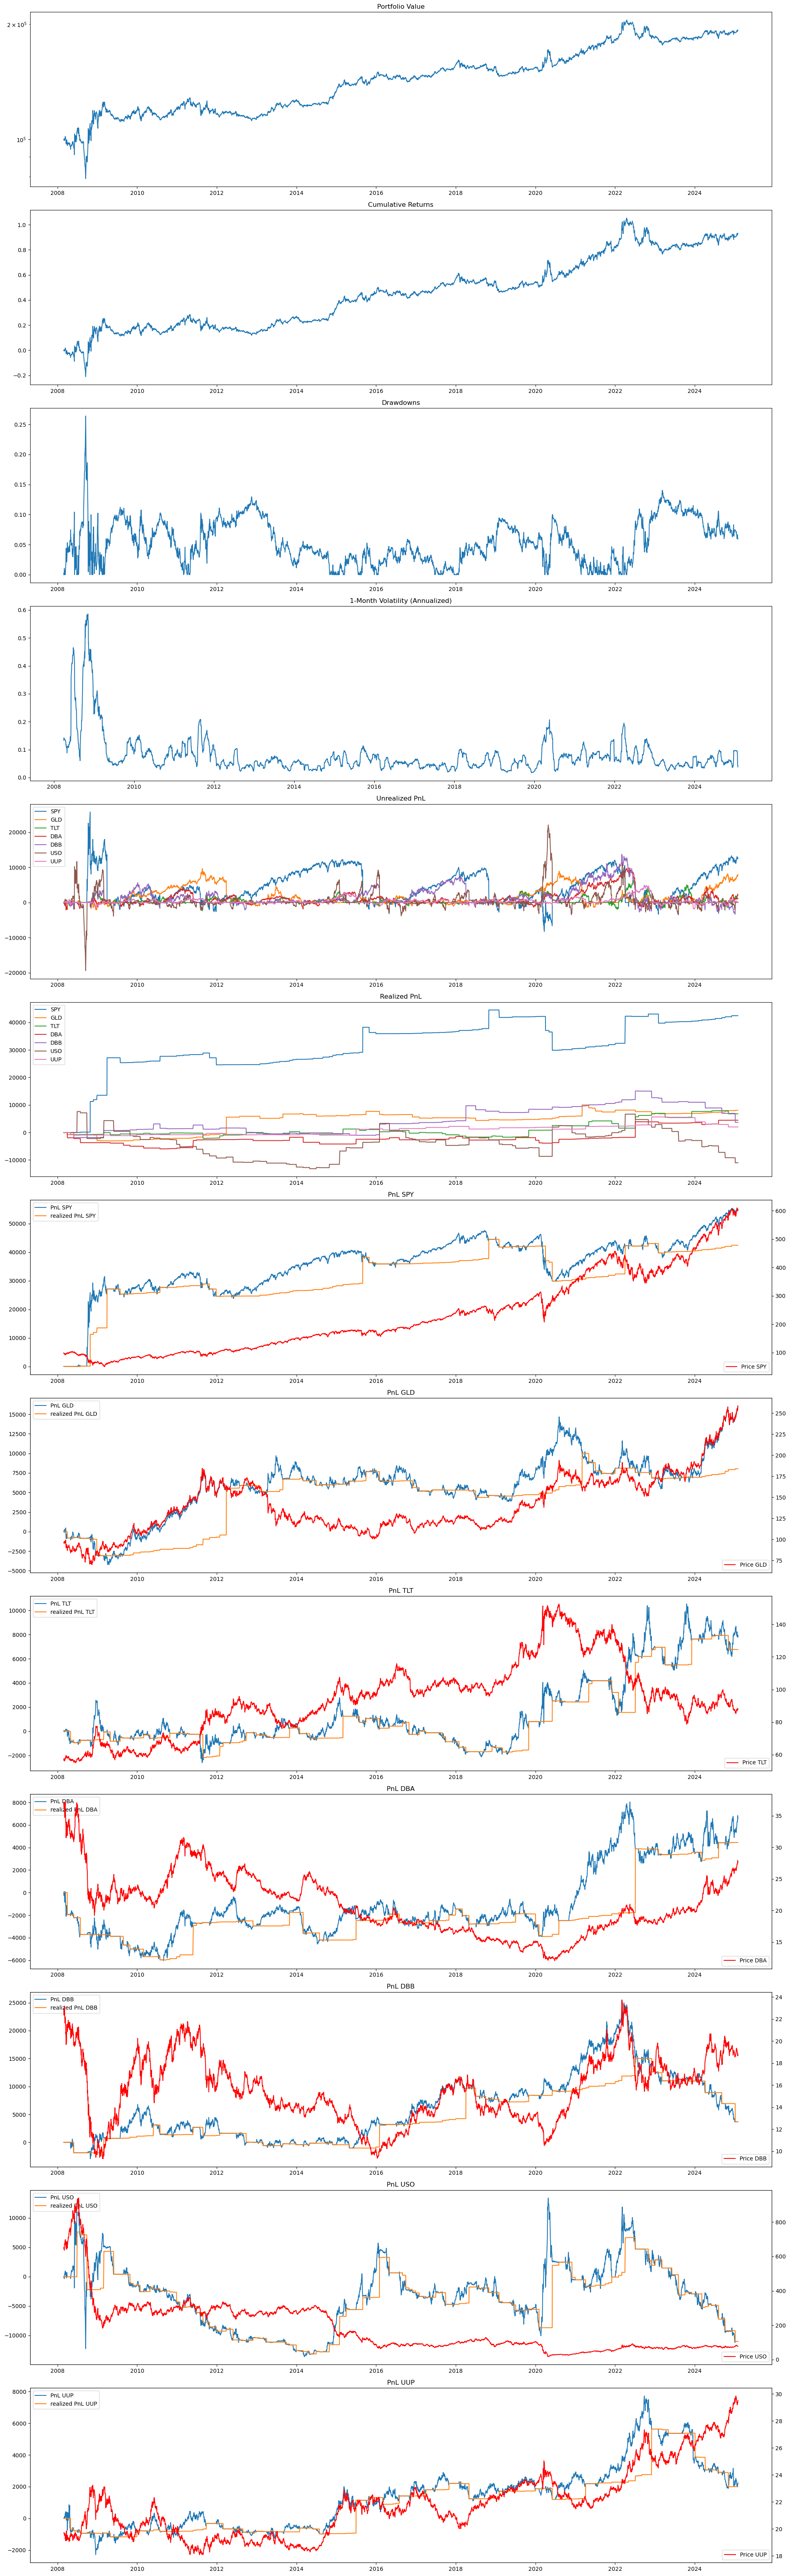

In [28]:
from strategies.trend_following import AdvancedTrendFollowingStrategy
# Initialize backtester
bt = BackTester(price_data)
bt.add_strategy(
    AdvancedTrendFollowingStrategy, 
    tickers=ticker_list, 
    price_data=price_data, 
    fast_lookback={ticker:  individual_asset_study_results[ticker][f'fast_lookback_{ticker}'] for ticker in ticker_list},
    slow_lookback={ticker:  individual_asset_study_results[ticker][f'slow_lookback_{ticker}'] for ticker in ticker_list},
    rebalance_period=21,
    atr_period=50,
    correction_fast_weight={ticker: individual_asset_study_results[ticker][f'correction_fast_weight_{ticker}'] for ticker in ticker_list},
    rebound_fast_weight={ticker: individual_asset_study_results[ticker][f'rebound_fast_weight_{ticker}'] for ticker in ticker_list},
    sma_trend_periods=(21, 252),
)
results = bt.backtest()
print("Trend following Results:", {k: v for k, v in results.items() if k != 'returns'})
bt.plot_results()

Trend following Results: {'cagr': 0.09404215050283438, 'volatility': 0.26257545931636356, 'sharpe': 0.3581528553646282, 'max_drawdown': 0.517209010885638, 'cumulative_returns': 3.947700905475614}


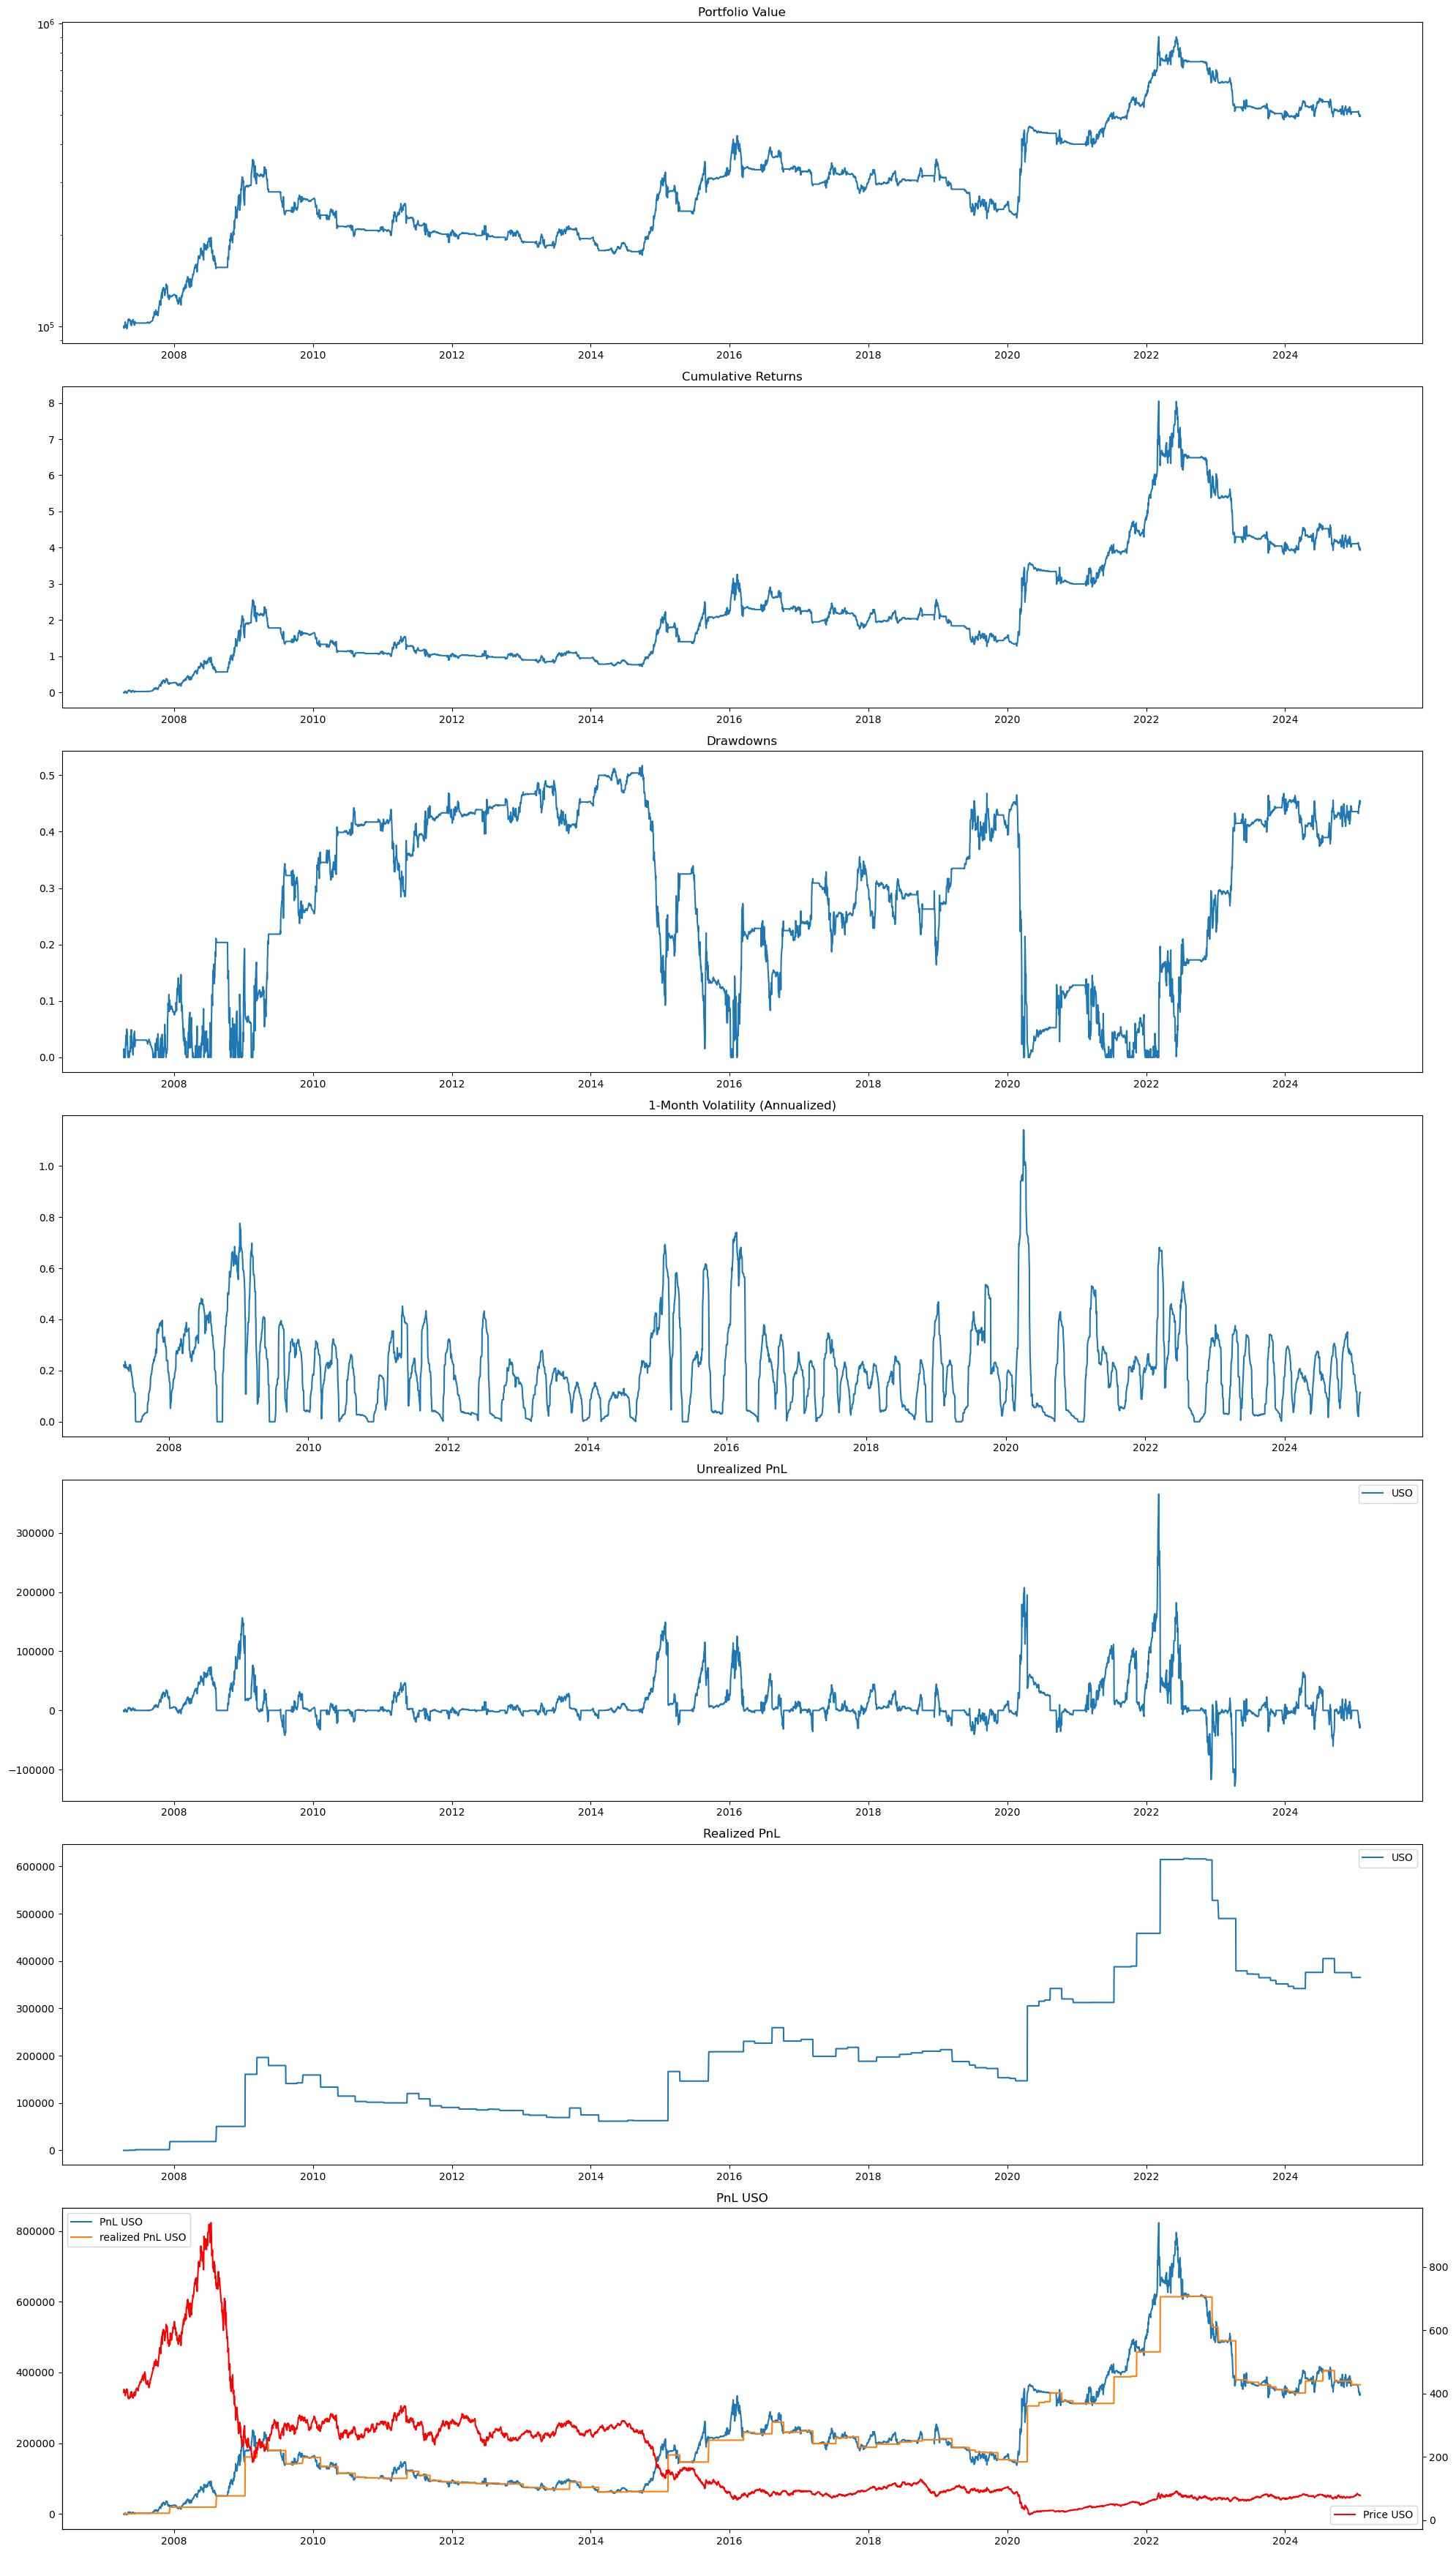

In [23]:
from strategies.trend_following import AdvancedTrendFollowingStrategy
# Initialize backtester

tl = ['USO']
pdd = {f: price_data[f] for f in tl}
bt = BackTester(pdd)
bt.add_strategy(
    AdvancedTrendFollowingStrategy, 
    tickers=tl, 
    price_data=pdd, 
    fast_lookback={ticker:  individual_asset_study_results[ticker][f'fast_lookback_{ticker}'] for ticker in tl},
    slow_lookback={ticker:  individual_asset_study_results[ticker][f'slow_lookback_{ticker}'] for ticker in tl},
    rebalance_period=21,
    atr_period=21,
    correction_fast_weight={ticker: individual_asset_study_results[ticker][f'correction_fast_weight_{ticker}'] for ticker in tl},
    rebound_fast_weight={ticker: individual_asset_study_results[ticker][f'rebound_fast_weight_{ticker}'] for ticker in tl},
    sma_trend_periods=(21, 252),
)
results = bt.backtest()
print("Trend following Results:", {k: v for k, v in results.items() if k != 'returns'})
bt.plot_results()